## Decision trees for ESC

Continuous output example: A prediction model that states the motor mass value from references of motor torque. Different decision trees are created according to the required selection criteria.

**Step 1**: Import the required libraries.

In [1]:
# import numpy package for arrays and stuff 
import numpy as np 

# import matplotlib.pyplot for plotting our result 
import matplotlib.pyplot as plt 

# import pandas for importing csv files 
import pandas as pd 


**Step 2**: Initialize and print the Dataset

In [2]:
import sys
sys.path.insert(0, 'decision trees')

from predicted_values_DT import *

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

path='./ESC/'
df = pd.read_csv(path+'Non-Dominated-ESC.csv', sep=';')
df_X = df[['Pmax_W','Vmax_V']] # we select the first five rows
df_y = df[['Weight_g']]


Tree structure

In [4]:
from IPython.display import Image  
from io import StringIO
import pydot  
from sklearn import tree

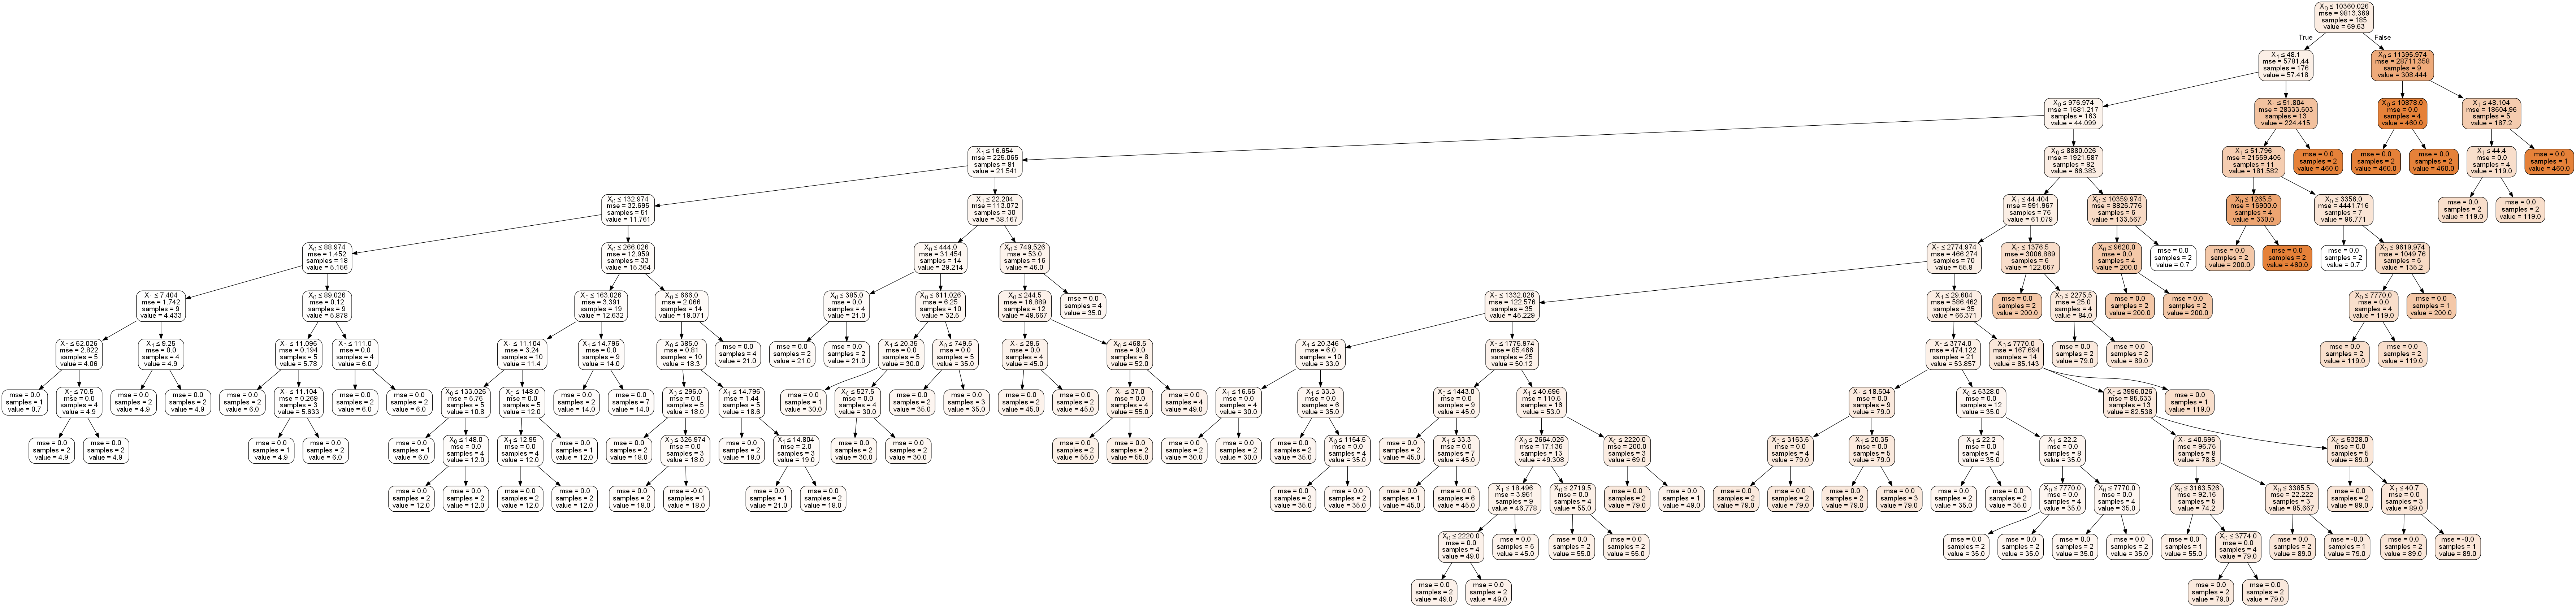

In [5]:
dot_data = StringIO()  
tree.export_graphviz(DT_handling(df_X,df_y,['next','next']), out_file=dot_data, 
    filled=True, rounded=True,
    special_characters=True)
graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph[0].create_png())  

3D plot - average values

In [10]:
# from sklearn.preprocessing import PolynomialFeatures
# from sklearn.metrics import mean_squared_error, r2_score
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np


%matplotlib widget 


In [11]:
# read dataframe values

X = (df[['Pmax_W','Vmax_V']].values)
y1 = (df[['Weight_g']].values)

# extracting columns from X
Pmax_col=X[:,0] 
Vmax_col=X[:,1]

#meshgrid 3D for plot

xx1,xx2= np.meshgrid(np.linspace(X[:,0].min(), X[:,0].max(), 100), 
                       np.linspace(X[:,1].min(), X[:,1].max(), 100))
positions = np.vstack([xx1.ravel(), xx2.ravel()]).T



#create the 3D axis 
fig = plt.figure(figsize=(10, 8))
ax = Axes3D(fig, azim=-210, elev=15)


xp = np.reshape(positions[:,0], (100, 100))
yp = np.reshape(positions[:,1], (100, 100))


# zp = np.reshape(DT_handling(X,y1,['next','next'],positions,20)[0], (100, 100))
zp = np.reshape(np.exp(DT_handling(np.log(X),np.log(y1),['next','next'],100).predict(np.log(positions))), (100, 100))


# ax.scatter(positions[:,0], positions[:,1], average_DT(df[['Tnom_Nm','Kt_Nm_A']],df[['r_omn']],positions), color='red', alpha=1.0, facecolor='white')
ax.plot_surface(xp, yp, zp, cmap=plt.cm.RdBu_r, alpha=0.7, linewidth=1)
ax.scatter(Pmax_col, Vmax_col, y1, color='black', alpha=1.0, facecolor='white')


#axis labels
ax.set_xlabel('Power (W) [-]',fontsize=14)
ax.set_ylabel('Voltage (V) [-]',fontsize=14)
ax.set_zlabel('Mass [g]',fontsize=14)

plt.grid()

plt.tick_params(axis = 'both', labelsize = 14)

FigureCanvasNbAgg()

**Step 3**: Fit decision tree regressor to the dataset

Decision Trees (DTs) are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. More information can be found under the following [reference](https://scikit-learn.org/stable/modules/tree.html).

Depending on the selection criteria, we define the following regression trees:
- Decision trees centered on the reference.
- Decision trees based on the selection of the previous value.
- Decision trees based on the selection of the next value.


**Step 3.1**: Decision tree centered on the reference:

The `sklearn.tree` module includes decision tree-based models for regression.

In [13]:
from sklearn.tree import DecisionTreeRegressor

df_X = df[['Pmax_W']] # we select the first five rows
df_y = df[['Vmax_V']]

plt.figure()
# create a regressor object (https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html)
regressorAver = DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=1,
           max_leaf_nodes=len(df_X), min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           random_state=None, splitter='best')

# fit the regressor with X and Y data 
regressorAver.fit(df_X.values.reshape(-1,1) , df_y.values.reshape(-1,1)) 


# arange for creating a range of values 
# from min value of X to max value of X 
# with a difference of 0.0001 between two 
# consecutive values 
X_grid = np.linspace(df_X.min(), df_X.max(), num=10000) 

# reshape for reshaping the data into 
# a len(X_grid)*1 array, i.e. to make 
# a column out of the X_grid values 
X_grid = X_grid.reshape((len(X_grid), 1)) 

# scatter plot for original data 
plt.scatter(df_X, df_y, color = 'red', label='references') 
# plt.scatter(df_X, df_y, color = 'red') 
# plt.xlim(df_X.min(), df_X.max())

# plot predicted data 
plt.plot(X_grid, regressorAver.predict(X_grid), color = 'black', label='decision tree based on average val.') 

# specify title 
plt.title('Non dominated references voltage to power (Decision Tree Regression)') 

# specify labels 
plt.xlabel('Max power [W]')
plt.ylabel('Max voltage [V]')

# plot the legend
plt.legend()
# show the plot 
plt.grid()
plt.show()

FigureCanvasNbAgg()

**Step 3.1.1**: Prediction of further values:

In [14]:
# predicting a new value 

# test the output by changing values, like 3750 
y_pred = regressorAver.predict(np.array([2.2]).reshape(1, 1)) 

# print the predicted price 
print("Predicted ESC voltage: % .3f V\n"% y_pred) 


Predicted ESC voltage:  7.400 V



**Step 3.2**: Decision trees based on the selection of the previous value:

The standard scikit learn decision tree regressor function generates a regression function, which selects the necessary splits to minimize the possible selection error (mse). This is normally achieved by using the average of each terminal node as splits (more information [here](https://towardsdatascience.com/https-medium-com-lorrli-classification-and-regression-analysis-with-decision-trees-c43cdbc58054)). However, if we want to force the split towards a certain point we must generate additional points, which do not affect our dataset too much.

*Example: Considering we have the points of X=[1,2,3] and Y=[5,6,7], and we want to construct a regression tree based on the previous values of Y, we have to add some additional points to force the regression pass by these points as we see in the example below.*

In [15]:
df_X_ex = np.array([1,1,1.9,1.9,2.1,2.1,2.9,2.9,3.1,3.1])
df_y_ex = np.array([4.9,5.1,4.9,5.1,5.9,6.1,5.9,6.1,6.9,7.1])
X_ex = np.array([1,2,3])
Y_ex = np.array([5,6,7])

# create a regressor object (https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html)
regressor = DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=1,
           max_leaf_nodes=len(df_X_ex), min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           random_state=None, splitter='best')

# fit the regressor with X and Y data
regressor.fit(df_X_ex.reshape(-1,1) , df_y_ex.reshape(-1,1)) 


# arange for creating a range of values 
# from min value of X to max value of X 
# with a difference of 0.01 between two 
# consecutive values 
X_grid = np.linspace(df_X_ex.min(), df_X_ex.max(), num=10000) 

# reshape for reshaping the data into 
# a len(X_grid)*1 array, i.e. to make 
# a column out of the X_grid values 
X_grid = X_grid.reshape((len(X_grid), 1)) 

# scatter plot for original data 
plt.scatter(X_ex,Y_ex, marker='x',label='references',color='black')

plt.scatter(df_X_ex, df_y_ex, color = 'red',label='supplementary points') 

# plot predicted data 
plt.plot(X_grid, regressor.predict(X_grid), color = 'blue', label='decision tree') 
plt.legend()
plt.grid()
plt.show()

Axis x

In [16]:
import numpy as np

# we call the x values of the dataframe
xy=pd.concat([df_X,df_y],axis=1)
sorted_xy = np.unique(xy,axis=0)

# a vector of supplementary points around the reference value to force the regression tree through X
C=(np.vstack((sorted_xy[:,0]-sorted_xy[:,0].min()/1000,sorted_xy[:,0]+sorted_xy[:,0].min()/10000)).ravel('F'))
D=np.repeat(C, 2)

df_X_Prev=(np.delete(np.delete(D,2),2))

Axis y

In [17]:
df_y1 = sorted_xy[:,1]
df_y1_C1 = df_y1-df_y1.min()/100
df_y1_C2 = df_y1+df_y1.min()/100
A=np.repeat(df_y1_C1, 2)
B=np.repeat(df_y1_C2, 2)
C=(np.vstack((A,B)).ravel('F'))
df_y_Prev=(C[:-2])

In [18]:
from sklearn.tree import DecisionTreeRegressor

plt.figure()

# select independent column
df_XPrev = df_X_Prev.reshape(-1,1)

# select dependent column
df_yPrev = df_y_Prev.reshape(-1,1)

# create a regressor object (https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html)
regressorPrev = DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=1,
           max_leaf_nodes=len(df_XPrev), min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           random_state=None, splitter='best')

# fit the regressor with X and Y data 
regressorPrev.fit(df_XPrev, df_yPrev) 


# arange for creating a range of values 
# from min value of X to max value of X 
# with a difference of 0.01 between two 
# consecutive values 
X_grid = np.linspace(min(df_XPrev), max(df_XPrev), num=10000) 

# reshape for reshaping the data into 
# a len(X_grid)*1 array, i.e. to make 
# a column out of the X_grid values 
X_grid = X_grid.reshape((len(X_grid), 1)) 

# scatter plot for original data 
plt.scatter(df_XPrev, df_yPrev, color = 'red',label='supplementary points') 
plt.scatter(df_X,df_y, color = 'k', label='references', marker='x')  

# plot predicted data 
plt.plot(X_grid, regressorPrev.predict(X_grid), color = 'blue',label='regression tree')

# specify title 
plt.title('Non dominated references voltage to power (Decision Tree Regression)') 

# specify labels 
plt.xlabel('Max power [W]')
plt.ylabel('Max voltage [V]')

# show the plot 
plt.grid()
plt.legend()
plt.show()

FigureCanvasNbAgg()

**Step 3.2.1.**: Prediction of further values:

In [32]:
# predicting a new value 

# test the output by changing values, like 3750 
y_pred = regressorPrev.predict(np.array([3.5]).reshape(1, 1)) 

# print the predicted price 
print("Predicted ESC voltage: % .3f V\n"% y_pred) 


Predicted ESC voltage:  7.400 V



**Step 3.3.**: Decision tree based on the selection of the next values

*Example: Considering we have the dataset of X=[1,2,3] and Y=[5,6,7], we want to trace a regression tree based on the next values of Y, we have to add some additional points to force the regression pass by these points as we see in the example below.*

<IPython.core.display.Javascript object>


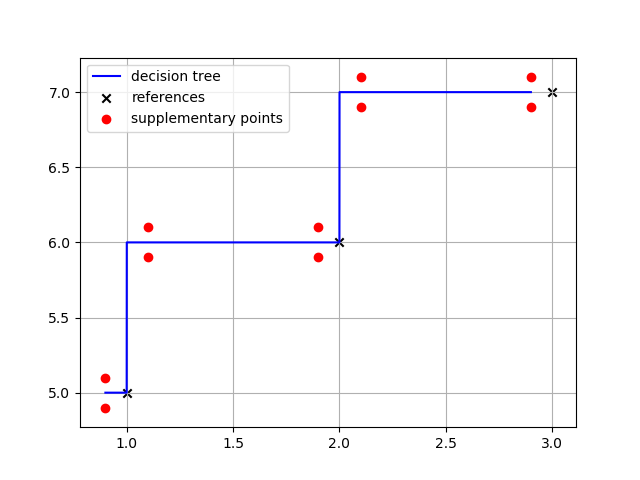

In [33]:
df_X_ex = np.array([0.9,0.9,1.1,1.1,1.9,1.9,2.1,2.1,2.9,2.9])
df_y_ex = np.array([4.9,5.1,5.9,6.1,5.9,6.1,6.9,7.1,6.9,7.1])
X_ex = np.array([1,2,3])
Y_ex = np.array([5,6,7])

plt.figure()

# create a regressor object (https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html)
regressor = DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=1,
           max_leaf_nodes=len(df_X), min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           random_state=None, splitter='best')

# fit the regressor with X and Y data
regressor.fit(df_X_ex.reshape(-1,1) , df_y_ex.reshape(-1,1)) 


# arange for creating a range of values 
# from min value of X to max value of X 
# with a difference of 0.01 between two 
# consecutive values 
X_grid = np.arange(min(df_X_ex), max(df_X_ex), 0.00001) 

# reshape for reshaping the data into 
# a len(X_grid)*1 array, i.e. to make 
# a column out of the X_grid values 
X_grid = X_grid.reshape((len(X_grid), 1)) 

# scatter plot for original data 
plt.scatter(X_ex,Y_ex, marker='x',label='references',color='black')

plt.scatter(df_X_ex, df_y_ex, color = 'red',label='supplementary points') 

# plot predicted data 
plt.plot(X_grid, regressor.predict(X_grid), color = 'blue', label='decision tree') 
plt.legend()
plt.grid()
plt.show()

Axis x

In [34]:
xy=pd.concat([df_X, df_y],axis=1)
sorted_xy = np.unique(xy,axis=0)
C=(np.vstack((sorted_xy[:,0]-sorted_xy[:,0].min()/1000,sorted_xy[:,0]+sorted_xy[:,0].min()/1000)).ravel('F'))
D=np.repeat(C, 2)
D=D[:-2]
df_XNext=D

Axis y

In [35]:
df_y1 = sorted_xy[:,1]
df_y1_C1 = df_y1-df_y1.min()/100
df_y1_C2 = df_y1+df_y1.min()/100
A=np.repeat(df_y1_C1, 2)
B=np.repeat(df_y1_C2, 2)
C=(np.vstack((A,B)).ravel('F'))
C=(np.delete(np.delete(C,2),2))
df_yNext=(C)

<IPython.core.display.Javascript object>


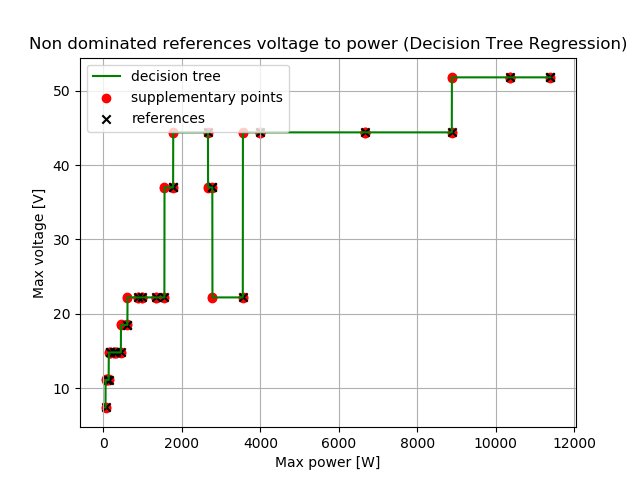

In [36]:
from sklearn.tree import DecisionTreeRegressor

plt.figure()

# select independent column
df_XNext = df_XNext.reshape(-1,1)

# select dependent column
df_yNext = df_yNext.reshape(-1,1)

# create a regressor object (https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html)
regressorNext = DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=1,
           max_leaf_nodes=len(df_XNext), min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           random_state=None, splitter='best')

# fit the regressor with X and Y data 
regressorNext.fit(df_XNext, df_yNext) 


# arange for creating a range of values 
# from min value of X to max value of X 
# with a difference of 0.01 between two 
# consecutive values 
X_grid = np.linspace(min(df_XNext), max(df_XNext), num=10000) 

# reshape for reshaping the data into 
# a len(X_grid)*1 array, i.e. to make 
# a column out of the X_grid values 
X_grid = X_grid.reshape((len(X_grid), 1)) 

# scatter plot for original data 

plt.scatter(df_XNext, df_yNext, color = 'red',label='supplementary points') 
plt.scatter(df_X ,df_y, marker='x',label='references',color='black')

# specify title 
plt.title('Non dominated references voltage to power (Decision Tree Regression)') 

# specify labels 
plt.xlabel('Max power [W]')
plt.ylabel('Max voltage [V]')

# plot predicted data 
plt.plot(X_grid, regressorNext.predict(X_grid), color = 'green', label='decision tree') 

# show the plot 
plt.grid()
plt.legend()
plt.show()


**Step 3.3.1.**: Prediction of further values:

In [37]:
# predicting a new value 

# test the output by changing values, like 3750 
y_pred = regressorNext.predict(np.array([3.5]).reshape(1, 1)) 

# print the predicted price 
print("Predicted ESC voltage: % .3f V \n"% y_pred) 


Predicted ESC voltage:  7.400 V 



**Step 4:** Display of all regression trees with references

<IPython.core.display.Javascript object>


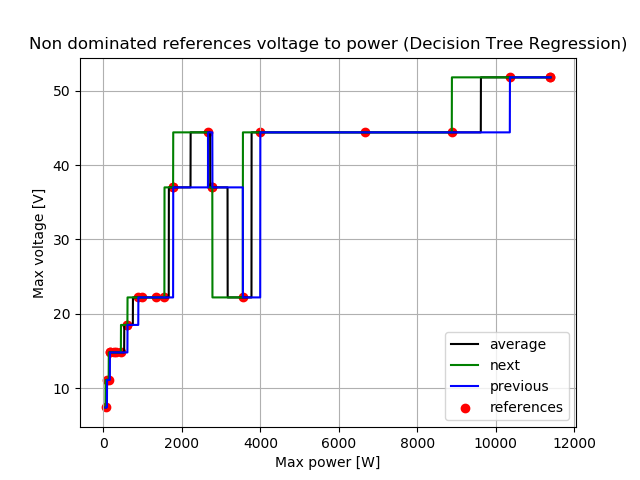

In [38]:
plt.figure()
plt.plot(X_grid, regressorAver.predict(X_grid), label = 'average', color='black') 
plt.plot(X_grid, regressorNext.predict(X_grid), label = 'next', color='green')
plt.plot(X_grid, regressorPrev.predict(X_grid), label = 'previous', color='blue')
plt.scatter(df_X ,df_y, label='references',color = 'red') 

plt.legend()

# specify title 
plt.title('Non dominated references voltage to power (Decision Tree Regression)') 

# specify labels 
plt.xlabel('Max power [W]')
plt.ylabel('Max voltage [V]')

# show the plot 
plt.grid()
plt.show()

**Step 6**: Build your decision tree. Example: decision tree based on previous values:

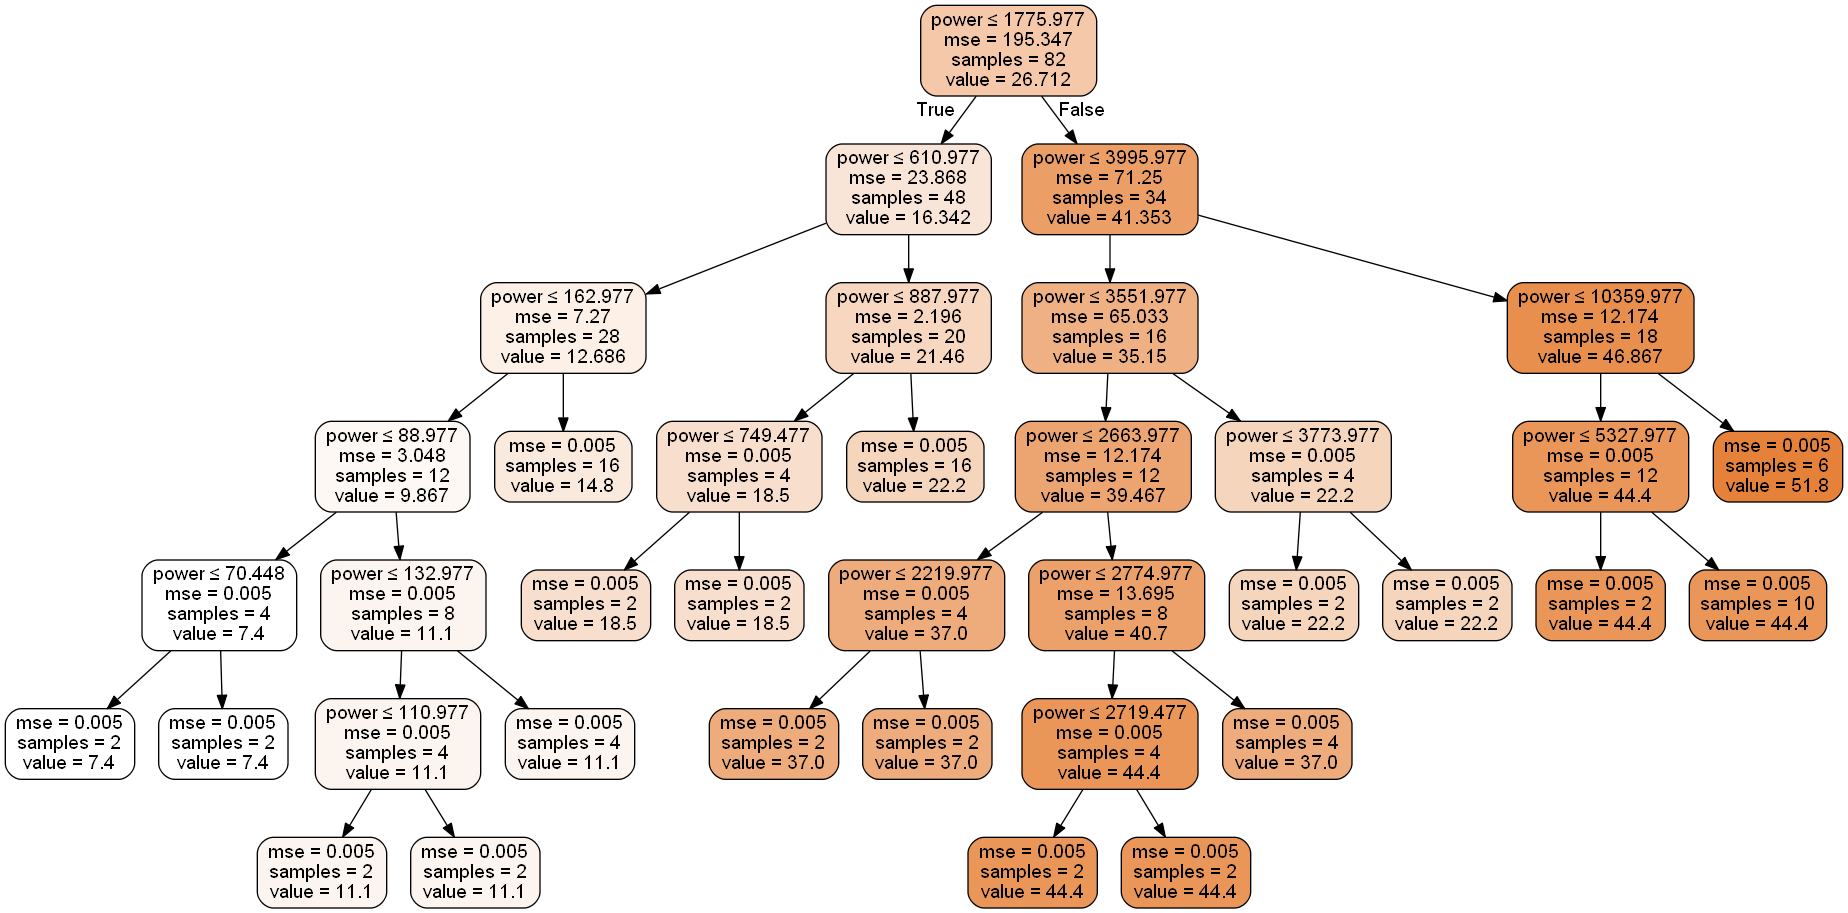

In [16]:
from IPython.display import Image  
from sklearn.externals.six import StringIO  
import pydot  
from sklearn import tree

dot_data = StringIO()  
tree.export_graphviz(regressorPrev, out_file=dot_data,  
    feature_names=['power'],
    filled=True, rounded=True,
    special_characters=True)
graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph[0].create_png())  

## Conclusions

#### Avantages
- Les arbres de decision nous permettent de travailler de manière échélonnée
- Ils nous permettent de prévoir de nouvelles valeurs, (ce qui sera utile lors de l'utilisation d'un code de dimensionnement).
- Code simplifié, moins encombrant que de travailler avec la structure

#### Inconvénients
- Les critères de fractionnement se font sur la base de certains paramètres préétablis, tels que la maximisation de l'MSE (Mean Squared Error) ou de l'EMA (Mean Absolute Error) ``criterion{“mse”, “friedman_mse”, “mae”}, default=”mse”``. (minimum number of decision nodes is not available as argument). Au contraire, nous sommes plus intéressés à travailler avec une sorte d'escalier

#### Alternatives
- Trace en escalier--> Difficulté à prévoir de nouvelles valeurs?
- Construire notre propre arbre de décision, où chaque division est faite pour chaque point--> 

## Stepwise function

<IPython.core.display.Javascript object>


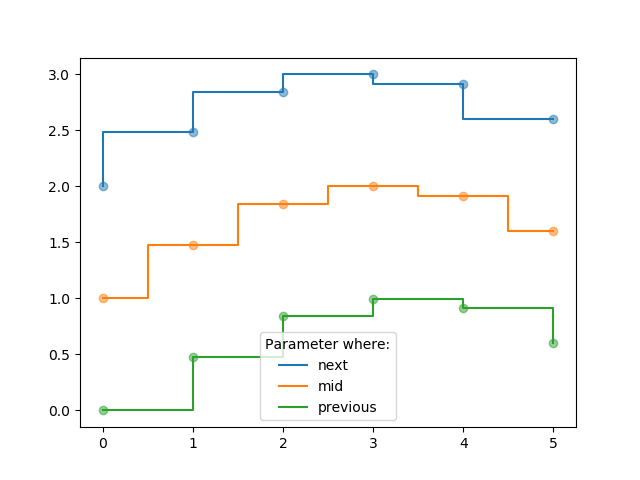

In [20]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure()


x = np.arange(6)
y = np.sin(x / 2)

plt.step(x, y + 2, label='next')
plt.plot(x, y + 2, 'C0o', alpha=0.5)

plt.step(x, y + 1, where='mid', label='mid')
plt.plot(x, y + 1, 'C1o', alpha=0.5)

plt.step(x, y, where='post', label='previous')
plt.plot(x, y, 'C2o', alpha=0.5)

plt.legend(title='Parameter where:')
plt.show()


``np.searchsorted`` finds index where the element should be inserted to maintain the order of the array.

In [44]:
value_ref=0.55

choose the next value

In [45]:
idx=np.searchsorted(x, value_ref) #blue
y[idx]+2

2.479425538604203

choose the previous value:

In [46]:
idx=np.searchsorted(x, value_ref) #blue
y[idx-1]

0.0

choose the closest value :

In [21]:
idx = (np.abs(x - value_ref)).argmin()
y[idx]+1

1.479425538604203

In [22]:
# try:
#     idx=np.searchsorted(x, value_ref) 
#     a=y[idx]+2
# except IndexError:
#     idx=len(x)
#     a=y[idx-1]+2
    
# a

## Build your own [decision tree](https://www.curiousily.com/posts/build-a-decision-tree-from-scratch-in-python/) (tbd)

In [23]:
# class Node:

#     def __init__(self, x, y, idxs, min_leaf=5):
#         self.x = x 
#         self.y = y
#         self.idxs = idxs 
#         print('init idxs')
#         print(idxs)
#         self.min_leaf = min_leaf
#         self.row_count = len(idxs)
#         self.col_count = x.shape[1]
#         self.val = np.mean(y[idxs])
#         self.score = float('inf')
#         self.find_varsplit()
        
#     def find_varsplit(self):
#         for c in range(self.col_count): self.find_better_split(c)
#         if self.is_leaf: 
#             print('ok isl')
#             return
#         x = self.split_col
#         lhs = np.nonzero(x <= self.split)[0]
#         print('lhs')
#         print(lhs)
#         rhs = np.nonzero(x > self.split)[0]
#         print('self.split find_varsplit')
#         print(self.split)
#         self.lhs = Node(self.x, self.y, self.idxs[lhs], self.min_leaf)
#         print('begin of rhs')
#         self.rhs = Node(self.x, self.y, self.idxs[rhs], self.min_leaf)
 

#     def find_better_split(self, var_idx):
      
#         x = self.x.values[self.idxs, var_idx]
#         print('x find better split')
#         print(x)
#         print('self.idxs')
#         print(self.idxs)
#         for r in range(self.row_count):
#             lhs = x <= x[r]
#             rhs = x > x[r]
#             if rhs.sum() < self.min_leaf or lhs.sum() < self.min_leaf: continue

#             curr_score = self.find_score(lhs, rhs)
#             if curr_score < self.score: 
#                 self.var_idx = var_idx
#                 self.score = curr_score
#                 self.split = x[r]
#                 print('self split x[r]')
#                 print(self.split)

#     def find_score(self, lhs, rhs):
#         y = self.y[self.idxs]
# #         print(y[lhs])
#         lhs_std = y[lhs].std()
#         rhs_std = y[rhs].std()
# #         print('find_score')
# #         print(lhs_std * lhs.sum() + rhs_std * rhs.sum())
#         return lhs_std * lhs.sum() + rhs_std * rhs.sum()
                
#     @property
#     def split_col(self): 
#         print('self.x.values[self.idxs,self.var_idx]')
#         print(self.x.values[self.idxs,self.var_idx])
#         return self.x.values[self.idxs,self.var_idx]
                
#     @property
#     def is_leaf(self): 
#         print('is_leaf')
#         return self.score == float('inf')                

#     def predict(self, x):
# #         for xi in x:
# #         print(x)
#         return np.array([self.predict_row(xi) for xi in x])

#     def predict_row(self, xi):
#         print('self.y[self.idxs]')
#         print((self.y[self.idxs]))
#         print('self.val')
#         print(self.val)
#         if self.is_leaf: 
#             print('self.is_leaf, self.val')
#             return self.val
#         node = self.lhs if xi[self.var_idx] <= self.split else self.rhs
#         print('node')
#         print(node)
#         print('self.lhs')
#         print(self.lhs)
#         print('xi[self.var_idx]')
#         print(xi[self.var_idx])
#         print('self.split')#coordenadas de x
#         print(self.split)#coordenadas de x
#         print('node.predict_row(xi)')
#         print(node.predict_row(xi))
#         return node.predict_row(xi)

In [24]:
# class DecisionTreeRegressor:
  
#   def fit(self, X, y, min_leaf = 5):
# #     print(X)
#     self.dtree = Node(X, y, np.array(np.arange(len(y))), min_leaf)
#     return self
  
#   def predict(self, X):
# #     print(X)
#     return self.dtree.predict(X.values)
    

In [25]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import numpy as np

# df_X=np.array([1,1,1.25,1.5,1.75,2,2,2.25,2.5,2.75,3,3,3.25,3.5,3.75,4,4,4.25,4.5,4.75,5,5])
# df_y=np.array([5,6,6,6,6,6,7,7,7,7,7,8,8,8,8,8,9,9,9,9,9,10])

# # df_X=np.array([1,1,1,2,2,2,3,3,3,4,4])
# # df_y=np.array([5,4,6,6,7,5,6,7,8,8,9])


# # select independent column
# df_X = pd.DataFrame(df_X)

# regressor = DecisionTreeRegressor().fit(df_X, df_y.T.squeeze())
# preds = regressor.predict(df_X)

# X_grid = np.arange(df_X.iloc[:, 0].min(), df_X.iloc[:, 0].max(), 1) 

# # X_grid = pd.DataFrame(X_grid)

# # reshape for reshaping the data into 
# # a len(X_grid)*1 array, i.e. to make 
# # a column out of the X_grid values 
# # X_grid = X_grid.reshape((len(X_grid), 1)) 

# # scatter plot for original data 
# plt.scatter(df_X.iloc[:, 0], df_y, color = 'red') 

# # plot predicted data 
# plt.plot(X_grid, regressor.predict(pd.DataFrame(X_grid)), color = 'blue') 

# # specify title 
# plt.title('Non dominated references mass to torque (Decision Tree Regression)') 

# # specify X axis label 
# plt.xlabel('Nominal torque [N.m]') 

# # specify Y axis label 
# plt.ylabel('Mass [g]') 

# # show the plot 
# plt.show()

In [26]:
# len(df_X)

In [27]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import numpy as np

# df_X=np.array([1,1.25,1.5,1.75,2,2,2.25,2.5,2.75,3,3,3.25,3.5,3.75,4,4,4.25,4.5,4.75,5])
# df_y=np.array([6,6,6,6,6,7,7,7,7,7,8,8,8,8,8,9,9,9,9,9])

# # select independent column
# df_X = pd.DataFrame(df_X)

# regressor = DecisionTreeRegressor().fit(df_X, df_y.T.squeeze(), min_leaf = 4)
# preds = regressor.predict(df_X)

# # # scatter plot for original data 
# # plt.scatter(df_X.iloc[:, 0], df_y, color = 'red') 

# # # plot predicted data 
# # X_grid = np.arange(df_X.iloc[:, 0].min(), df_X.iloc[:, 0].max(), 0.5) 

# # plt.plot(X_grid, regressor.predict(pd.DataFrame(X_grid)), color = 'blue') 


In [28]:
# X_grid = np.arange(df_X.iloc[:, 0].min(), df_X.iloc[:, 0].max(), 0.01) 

# # X_grid = pd.DataFrame(X_grid)

# # reshape for reshaping the data into 
# # a len(X_grid)*1 array, i.e. to make 
# # a column out of the X_grid values 
# # X_grid = X_grid.reshape((len(X_grid), 1)) 

# # scatter plot for original data 
# plt.scatter(df_X.iloc[:, 0], df_y, color = 'red') 

# # plot predicted data 
# plt.plot(X_grid, regressor.predict(pd.DataFrame(X_grid)), color = 'blue') 

# # specify title 
# plt.title('Non dominated references mass to torque (Decision Tree Regression)') 

# # specify X axis label 
# plt.xlabel('Nominal torque [N.m]') 

# # specify Y axis label 
# plt.ylabel('Mass [g]') 

# # show the plot 
# plt.show()

In [29]:
# reg.predict(np.array([2.1]).reshape(1, 1)) 

In [30]:
# import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)


# import numpy as np
# import pandas as pd
# import seaborn as sns
# from pylab import rcParams
# import matplotlib.pyplot as plt
# import matplotlib.animation as animation
# from matplotlib import rc
# import unittest
# import math
# from sklearn import metrics
# from sklearn.tree import export_graphviz
# import IPython, graphviz, re

# def draw_tree(t, df, size=10, ratio=0.6, precision=0):
#     """ Draws a representation of a random forest in IPython.
#     Parameters:
#     -----------
#     t: The tree you wish to draw
#     df: The data used to train the tree. This is used to get the names of the features.
#     Source from: https://github.com/fastai/fastai/blob/e6b56de53f80d2b2d39037c82d3a23ce72507cd7/old/fastai/structured.py#L22
#     """
#     s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True,
#                       special_characters=True, rotate=True, precision=precision)
#     IPython.display.display(graphviz.Source(re.sub('Tree {',
#        f'Tree {{ size={size}; ratio={ratio}', s)))

In [31]:
# from sklearn.ensemble import RandomForestRegressor

# reg = RandomForestRegressor(n_estimators=1, max_depth=2, bootstrap=False, random_state=1)
# reg.fit(df_X, df_y.T.squeeze())

# draw_tree(reg.estimators_[0], df_X, precision=2)



In [32]:
# reg

In [33]:
# from sklearn.ensemble import RandomForestRegressor

# import pandas as pd
# import matplotlib.pyplot as plt
# import numpy as np

# df_X=np.array([1,1,1,1.5,2,2,2,3,3,3,4,4])
# df_y=np.array([5,4,6,5,6,7,5,6,7,8,8,9])

# # select independent column
# df_X = df_X.reshape(-1,1)

# reg = RandomForestRegressor(n_estimators=1, max_depth=2, bootstrap=False)
# reg.fit(df_X, df_y)

# # arange for creating a range of values 
# # from min value of X to max value of X 
# # with a difference of 0.01 between two 
# # consecutive values 
# X_grid = np.arange(min(df_X), max(df_X), 0.01) 

# # reshape for reshaping the data into 
# # a len(X_grid)*1 array, i.e. to make 
# # a column out of the X_grid values 
# X_grid = X_grid.reshape((len(X_grid), 1)) 

# # scatter plot for original data 
# plt.scatter(df_X, df_y, color = 'red') 

# # plot predicted data 
# plt.plot(X_grid, reg.predict(X_grid), color = 'blue') 

# # specify title 
# plt.title('Non dominated references mass to torque (Decision Tree Regression)') 

# # specify X axis label 
# plt.xlabel('Nominal torque [N.m]') 

# # specify Y axis label 
# plt.ylabel('Mass [g]') 

# # show the plot 
# plt.show()

In [34]:
# reg.predict(np.array([1.1]).reshape(1, 1)) 

In [35]:
# var_idx = df_X.shape[1]
# idxs=np.array(np.arange(len(df_y)))
# row_count=len(idxs)
# x = df_X.values[idxs, 0]

# for r in range(row_count):
#   lhs=x<=x[r]
#   rhs=x>=x[r]

In [36]:
# rhs.sum()

In [37]:
# lhs